In [ ]:
!git clone https://github.com/KHOATIEU123/demo.git

Các thư viện được sử dụng
- `pandas`: Thư viện được sử dụng để làm việc với dữ liệu dạng bảng.(cụ thể là file data.csv trong bài)
- `librosa`: Thư viện được sử dụng để xử lý âm thanh và tính toán các đặc trưng âm thanh.
- `numpy`: Thư viện cung cấp các công cụ để làm việc với mảng và ma trận.
- `matplotlib.pyplot`: Thư viện được sử dụng để tạo và hiển thị đồ thị.

In [7]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import random

- `metadata_file = "jpt-wtf/data.csv"` và `audio_folder = "jpt-wtf/audio"`: Khai báo đường dẫn cho tệp dữ liệu và thư mục âm thanh.

- `df = pd.read_csv(metadata_file)`: Đọc tệp CSV và lưu dữ liệu vào DataFrame `df`.

- `target_sr = 44100`: Tần số lấy mẫu mục tiêu cho xử lý âm thanh.

- `max_length = 10`: Độ dài tối đa (tính theo giây) của mỗi file âm thanh.

- `shift_range = 0.2`: Khoảng dịch chuyển tối đa (tính theo phần trăm độ dài) khi tạo các timéshift.

- `num_time_masks = 2` và `num_freq_masks = 2`: Số lượng time mask và frequency mask được áp dụng lên mẫu melspectrogram.

- `max_time_mask_length = 50` và `max_freq_mask_length = 10`: Độ dài tối đa (số frame và số bin tần số) của time mask và frequency mask.

In [8]:
metadata_file = "jpt-wtf/data.csv"
df = pd.read_csv(metadata_file)

audio_folder = "jpt-wtf/audio"
target_sr = 44100
max_length = 10
shift_range = 0.2
num_time_masks = 2
num_freq_masks = 2
max_time_mask_length = 50
max_freq_mask_length = 10

Điều chỉnh phổ âm thanh Mel bằng cách ẩn đi một phần dữ liệu trong không gian thời gian và tần số, sử dụng các `mask` có độ dài và số lượng được chỉ định. Kết quả trả về là phổ âm thanh `Mel Spectrogram` đã được điều chỉnh.

In [9]:
def spec_augment(mel_spec, num_time_masks, num_freq_masks, max_time_mask_length, max_freq_mask_length):
    augmented_spec = mel_spec.copy()
    num_bins, num_frames = augmented_spec.shape
    for _ in range(num_time_masks):
        mask_length = random.randint(0, max_time_mask_length)
        mask_start = random.randint(0, num_frames - mask_length)
        augmented_spec[:, mask_start:mask_start + mask_length] = 0
    for _ in range(num_freq_masks):
        mask_length = random.randint(0, max_freq_mask_length)
        mask_start = random.randint(0, num_bins - mask_length)
        augmented_spec[mask_start:mask_start + mask_length, :] = 0

    return augmented_spec

Chia dữ liệu thành các `batch` và `tạo danh sách đường dẫn âm thanh` tương ứng với mỗi `batch`.

In [10]:
batch_size = 32
num_batches = (len(df) - 1) // batch_size + 1

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(df))

    audio_paths = audio_folder + '/' + df['slice_file_name'].values[start_idx:end_idx]

Tiền xử lý dữ liệu, chuyển audio qua `Mono`, `căn chỉnh độ dài`, và tính toán `Spectrogram qua dB`, cuối cùng là `phổ âm thanh`.

In [11]:
for audio_path in audio_paths:
        audio, sr = librosa.load(audio_path, sr=None)
        if audio.ndim > 1:
            audio = librosa.core.to_mono(audio)
        if sr != target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        target_length = int(max_length * target_sr)

        if len(audio) < target_length:
            shortage = target_length - len(audio)
            silence = np.zeros(shortage)
            audio = np.concatenate((audio, silence))
        elif len(audio) > target_length:
            audio = audio[:target_length]

        shift_amount = int(shift_range * target_sr)
        shift_direction = np.random.choice([-1, 1])
        audio_shifted = np.roll(audio, shift_amount * shift_direction)
        mel_spec = librosa.feature.melspectrogram(y=audio_shifted, sr=target_sr, n_fft=2048, hop_length=512)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        augmented_spec = spec_augment(log_mel_spec, num_time_masks, num_freq_masks, max_time_mask_length, max_freq_mask_length)

Tạo và hiển thị hai hình ảnh phổ âm thanh `Mel Spectrogram` trước và sau khi xử lí.

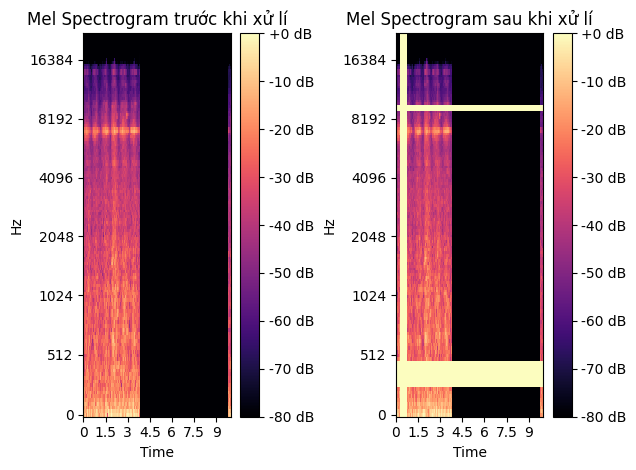

In [13]:
plt.figure(num='Khoa Tiêu -' + audio_path, figsize=(10, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(log_mel_spec, sr=target_sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram trước khi xử lí')
plt.subplot(1, 2, 2)
librosa.display.specshow(augmented_spec, sr=target_sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram sau khi xử lí')
plt.tight_layout()
plt.show()